# Narrow-band signal analysis - SNR, SINAD, THD, ENOB, WTF...



The signal analysis method(s) described here are very popular for characterising the perfomance of ADC-s.
However, it should be also applicable for finding the right gain values for transmitting/receiving RF signals. The benefit of using a single unmodulated sine wave is to easily identify and distinguish harmonics (due to distortion) from noise. Using wide-band sources for estimating the transfer function of the channel cannot do this, but should be the next logical step after finding the optimal TX/RX gain values.

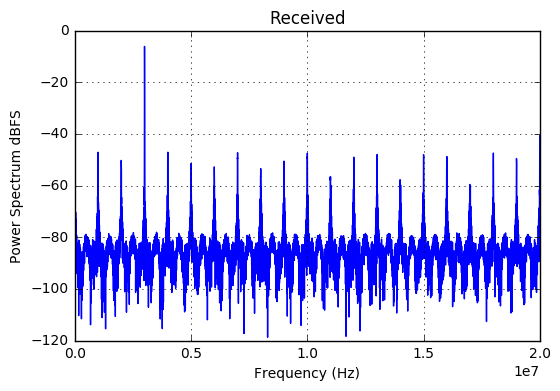

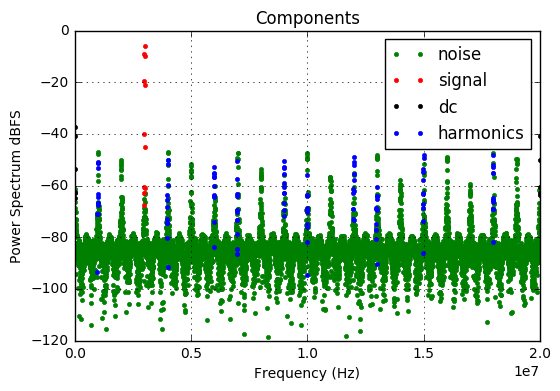

Signal power: -3.1 dB
DC power: -34.4 dB
Noise power: -31.6 dB
SNR: 28.5 dB, SINAD: 27.4 dB, THD: -33.9 dB (0.0 %), ENOB: 4 bits


In [335]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

# tunable params
fs = 20e6
freq = 3 * fs / 20
n_fft = 8192
channel_width = 6
n_harmonics = 10
epsilon = np.finfo(float).eps

# generate signal
t = np.linspace(0, n_fft/fs, n_fft)
signal = np.exp(2j * np.pi * freq * t) * 0.7
noise = np.random.randn((n_fft)) * 0.001 # to be correct, this should be complex, too
dc = np.ones((n_fft)) * 0.02
samples = np.clip(signal + noise + dc, -.699, .699) # distortion


# calculate spectrum
f = np.linspace(0, fs, n_fft)
win = get_window('blackmanharris', n_fft)
x = np.fft.fft(win * samples, n=n_fft) / n_fft / np.sqrt(np.sum(win ** 2)  / n_fft)
spectrum = np.abs(x)**2

plt.plot(f, 10*np.log10(spectrum))
plt.ylim(-120, 0)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum dBFS')
plt.title('Received')
plt.show()


# divide frequency bins: signal, harmonics, noise, DC
all_bins = np.arange(n_fft)

def freq_to_bin(freq):
    return int(freq / fs * n_fft) % n_fft

sig_bin = freq_to_bin(freq)
dc_bin = 0
harmonic_bins = np.arange(2, 2+n_harmonics, dtype=np.int) * sig_bin % len(all_bins)
harmonic_bins = [(freq * i) for i in range(2, 2 + n_harmonics)]

def bin_distance(bin1, bin2):
    d1= (bin1 - bin2) % len(all_bins)
    d2 = (bin2 - bin1) % len(all_bins)
    return min(d1, d2)

sig_channel = []
dc_channel = []
harmonic_channels = []
noise_channels = []
for b in all_bins:
    if  bin_distance(b, sig_bin) < channel_width:
        sig_channel.append(b)
        continue
    if bin_distance(b, dc_bin) < channel_width:
        dc_channel.append(b)
        continue
    for harmonic_bin in harmonic_bins:
        if bin_distance(b, harmonic_bin) < channel_width:
            harmonic_channels.append(b)
            break
    else:
        noise_channels.append(b)

plt.plot(f[noise_channels], 10 * np.log10(spectrum[noise_channels] + epsilon), 'g.')
plt.plot(f[sig_channel], 10 * np.log10(spectrum[sig_channel] + epsilon), 'r.')
plt.plot(f[dc_channel], 10 * np.log10(spectrum[dc_channel] + epsilon), 'k.')
plt.plot(f[harmonic_channels], 10 * np.log10(spectrum[harmonic_channels] + epsilon), 'b.')
plt.legend(['noise', 'signal', 'dc', 'harmonics']);
plt.ylim(-120, 0)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum dBFS')
plt.title('Components')
plt.show()

# assuming white noise
avg_noise_per_bin = np.sum(spectrum[noise_channels]) / len(noise_channels)

sig_pow = np.sum(spectrum[sig_channel]) - (avg_noise_per_bin * len(sig_channel))
dc_pow = np.sum(spectrum[dc_channel]) - (avg_noise_per_bin * len(dc_channel))
harmonic_pow = np.sum(spectrum[harmonic_channels]) - (avg_noise_per_bin * len(harmonic_channels))
noise_pow = avg_noise_per_bin * len(all_bins) 

# safeguards:
sig_pow = max(sig_pow, epsilon)
dc_pow = max(dc_pow, epsilon)
harmonic_pow = max(harmonic_pow, epsilon)
noise_pow = max(noise_pow, epsilon)

snr = 10 * np.log10(sig_pow / noise_pow)
sinad = 10 * np.log10(sig_pow / (noise_pow + harmonic_pow))
thd = 10 * np.log10(harmonic_pow / sig_pow)
thd_pct = 100.0 * harmonic_pow / sig_pow 
enob = (sinad - 1.76) /6.02

print("Signal power: %.1f dB" % (10 * np.log10(sig_pow)))
print("DC power: %.1f dB" % (10 * np.log10(dc_pow)))
print("Noise power: %.1f dB" % (10 * np.log10(noise_pow)))
print("SNR: %.1f dB, SINAD: %.1f dB, THD: %.1f dB (%.1f %%), ENOB: %d bits" % (snr, sinad, thd, thd_pct, int(enob)))
